In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import matplotlib
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go

import math
import os
import gc
import argparse
import torch
import optuna
import joblib
import pickle
import tifffile
import nibabel
import scipy.io
import pygsp
import scipy.ndimage
import pyod
import warnings
import hashlib
import sqlite3

from scipy.stats import entropy, kurtosis, skew
from sklearn.mixture import GaussianMixture
from torch_geometric.utils import dense_to_sparse
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering
from sklearn.metrics import pairwise_distances

from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.cblof import CBLOF
from pyod.models.kpca import KPCA

from torch import nn, Tensor
from torch.nn import Linear, Conv1d, LayerNorm, DataParallel, ReLU, Sequential, Parameter
from torch_geometric.nn.dense import mincut_pool, dense_mincut_pool
from torch_geometric.datasets import AttributedGraphDataset
from torch_geometric.utils import to_networkx, subgraph, to_dense_adj

import source.nn.models as models
import source.utils.utils as utils
import source.utils.fault_detection as fd

from source.utils.utils import roc_params, compute_auc, get_auc, best_mcc, best_f1score, otsuThresholding
from source.utils.utils import synthetic_timeseries
from source.utils.utils import plotly_signal


from importlib import reload
models = reload(models)
utils = reload(utils)

from pyprojroot import here
root_dir = str(here())

data_dir = os.path.expanduser('~/data/interim/')

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'font.family': 'DejaVu Serif'})

pd.set_option('display.max_rows', 500)


In [40]:
epochs_list = [1,5,10,25,50,100,150,200,300,500,750,1000,1250]

def locality_data(node_positions, num_timestamps, label, wave_params=None,
                         anomaly_level=0.5, noise=0, seed=None):

    if seed is not None:
        np.random.seed(seed)

    dim = node_positions.shape[1]
        
    if wave_params is None:
        wave_params = {'wave_source': np.random.random(dim), 'wave_speed': 0.05, 'frequency': 0.25,
                       'wave_amp':1}

    num_nodes = node_positions.shape[0]

    wave_source = wave_params.get('wave_source', np.random.random(dim))
    wave_speed = wave_params.get('wave_speed', 0.05)
    frequency = wave_params.get('frequency', 0.25)
    w_amp = wave_params.get('wave_amp', 1)

    data_matrix = np.zeros((num_nodes, num_timestamps))

    t = np.arange(num_timestamps)

    t_start = np.random.randint(low=int(0.1*num_timestamps), high=int(0.5*num_timestamps))
    anomaly_base = np.zeros(num_timestamps)
    anomaly_base[t_start:t_start+int(0.3*num_timestamps)] = anomaly_level

    for i, pos in enumerate(node_positions):
        d_wave = np.linalg.norm(pos - wave_source)
        healthy = w_amp*np.sin(2 * np.pi * frequency * (d_wave - wave_speed * t))  * np.exp(-d_wave)
        data_matrix[i, :] = healthy

    anomalous_nodes = np.where(label==1)[0]
    anomaly_base = np.zeros(num_timestamps)
    anomaly_base[t_start:t_start+int(0.3*num_timestamps)] = anomaly_level
    for node in anomalous_nodes:
        data_matrix[node,:] += anomaly_base

    normal_nodes = np.where(label==0)[0]
    noise_nodes = np.random.choice(normal_nodes, size=int(noise*len(normal_nodes)), replace=False)
    t_start = np.random.randint(low=int(0.1*num_timestamps), high=int(0.5*num_timestamps))
    noise_base = np.zeros(num_timestamps)
    noise_base[t_start:t_start+int(0.3*num_timestamps)] = anomaly_level
    
    for node in noise_nodes:
        data_matrix[node,:] += noise_base

    return data_matrix, label

def select_walk(G, Number_of_nodes, walk_length=10):
    A = G.A.toarray()
    start_node = np.random.choice(G.N)

    selected_nodes = set([start_node])
    current_node = start_node

    while len(selected_nodes) < Number_of_nodes:
        # Perform a random walk starting from the last visited node
        for _ in range(walk_length):
            neighbors = np.where(A[current_node, :] > 0)[0]

            # Check if there are neighbors to walk to
            if len(neighbors) == 0:
                break  # Exit if the node has no neighbors

            # Randomly select the next step in the walk
            current_node = np.random.choice(neighbors)

            # Add the resulting node to the selected set if not already added
            selected_nodes.add(current_node)

            # Stop if we’ve reached the desired number of nodes
            if len(selected_nodes) >= Number_of_nodes:
                break

        # Restart the random walk from the start node if we still need more nodes
        current_node = start_node

    return list(selected_nodes)

def skewscore(scores, skewth):
    sk = skew(scores)
    return (1-scores) if (sk<skewth) else scores

def train_model(model, X, G, device, weight_loss, lr):

    rng_seed = 0
    torch.manual_seed(rng_seed)
    torch.cuda.manual_seed(rng_seed)
    np.random.seed(rng_seed)

    loss_evo = []
    loss_mc_evo = []
    loss_o_evo = []
    S_partials = []

    # Node coordinates
    A = torch.tensor(G.W.toarray()).float() #Using W as a float() tensor
    A = A.to(device)    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    model.reset_parameters()
    for epoch in range(1, 1+np.max(epochs_list)):

        optimizer.zero_grad()
        S, loss_mc, loss_o = model(X, A)
        loss = loss_mc + weight_loss*loss_o
        loss.backward()
        optimizer.step()
        loss_evo.append(loss.item())
        loss_mc_evo.append(loss_mc.item())
        loss_o_evo.append(loss_o.item())
        if epoch in epochs_list:
            S_partials.append(S)

    return S_partials, loss_mc_evo, loss_o_evo

def test_locality(model, datasets, epochs, weight_loss, lr, skewth, device):

    id_list = []
    sample_list = []
    auc_list = []
    f1_list = []
    mcc_list = []
    VR_list = []
    DR_list = []

    it = 0
    for dataset in datasets:

        print(f'Testing dataset {it}', flush=True)
        it+=1

        G = dataset['G']
        data = dataset['data']
        labels = dataset['labels']

        id = dataset['metadata']['id']
        n_samples = dataset['metadata']['samples']

        for sample in range(n_samples):
            X = torch.tensor(data[sample]).float().to(device)
            label = labels[sample]

            pos_anom = G.coords[np.where(label)[0],:]
            pos_data = G.coords

            VR = pos_anom.var(axis=0).mean()/pos_data.var(axis=0).mean()
            DR = pairwise_distances(pos_anom).max()/pairwise_distances(pos_data).max()

            S_epoch = train_model(model, X, G, device, weight_loss, lr)[0]

            epochs_id = epochs_list.index(epochs)
            scores = S_epoch[epochs_id].detach().cpu().softmax(dim=1).max(dim=1)[0].numpy()

            scores = skewscore(scores, skewth)

            id_list.append(id)
            sample_list.append(sample)
            auc_list.append(get_auc(scores, label).round(3))
            f1_list.append(best_f1score(scores, label).round(3))
            mcc_list.append(best_mcc(scores, label).round(3))
            VR_list.append(VR)
            DR_list.append(DR)
    
    df_test = pd.DataFrame({'id':id_list,
                            'VR':VR_list,
                            'DR':DR_list,
                            'sample_id':sample_list,
                            'AUC':auc_list,
                            'F1 score':f1_list,
                            'MCC':mcc_list})

    return df_test



In [10]:
# GATHERING SAMPLES WITH DESIRED VRs

metadata = {'samples':50,
            'SEED':0,
            'GRAPH_SEED':0,
            'N':400,
            'T':100,
            'wave_params': {'wave_speed': 0.05, 'frequency': 0.25, 'w_amp':0.5},
            'noise':0.1
            }

G = pygsp.graphs.Sensor(metadata['N'], n_try=1000, distribute=True, seed=metadata['GRAPH_SEED'])

VR_list = []
DR_list = []

bins = np.array([bin/10 for bin in range(1,9)])

VR_bins = {str(bin):[] for bin in bins}
VRmin = np.min([len(VR_bins[bin]) for bin in VR_bins])

seed = 0
while VRmin < metadata['samples']:
    np.random.seed(seed)
    label = np.zeros(metadata['N'])
    label[select_walk(G, 40, 40)] = 1

    pos_anom = G.coords[np.where(label)[0],:]
    pos_data = G.coords

    VR = pos_anom.var(axis=0).mean()/pos_data.var(axis=0).mean()
    if VR<bins.max():
          
        vrbin = bins[np.where(VR<bins)][0]

        # DR = pairwise_distances(pos_anom).max()/pairwise_distances(pos_data).max()

        if len(VR_bins[str(vrbin)])<metadata['samples']:
            VR_bins[str(vrbin)].append(seed)

    VRmin = np.min([len(VR_bins[bin]) for bin in VR_bins])
    seed += 1

In [13]:
datasets = []
for bin in VR_bins:

    metadata = {'samples':50,
                'bin':bin,
                'GRAPH_SEED':0,
                'N':400,
                'T':100,
                'wave_params': {'wave_speed': 0.05, 'frequency': 0.25, 'w_amp':0.5},
                'noise':0.1
                }

    G = pygsp.graphs.Sensor(metadata['N'], n_try=1000, distribute=True, seed=metadata['GRAPH_SEED'])

    dataset = {'data':[], 'labels':[], 'G':G, 'metadata':metadata}

    for seed in VR_bins[bin]:
        np.random.seed(seed)
        label = np.zeros(metadata['N'])
        label[select_walk(G, 40, 40)] = 1

        X = locality_data(G.coords, metadata['T'], label, metadata['wave_params'], noise=0.2)[0]
        dataset['data'].append(X)
        dataset['labels'].append(label)

    datasets.append(dataset)


In [15]:
device='cuda:2'
study = joblib.load(root_dir+f'/outputs/HP_training/ST_MC.pkl')
best_params = study.best_params
model = models.ClusterTS(metadata['T'], n_clusters=best_params['n_clusters'])
model = model.to(device)

In [ ]:
df_test = test_locality(model, datasets,
                        epochs=best_params['N_epochs'],
                        weight_loss=best_params['weight_loss'],
                        lr=best_params['lr'],
                        skewth=best_params['skewth'],
                        device=device
                    )
df_test.to_parquet(root_dir+'/outputs/testing_mincut/df_locality_VR.parq')


In [37]:
# GATHERING SAMPLES WITH DESIRED DRs

metadata = {'samples':50,
            'SEED':0,
            'GRAPH_SEED':0,
            'N':400,
            'T':100,
            'wave_params': {'wave_speed': 0.05, 'frequency': 0.25, 'w_amp':0.5},
            'noise':0.1
            }

G = pygsp.graphs.Sensor(metadata['N'], n_try=1000, distribute=True, seed=metadata['GRAPH_SEED'])

VR_list = []
DR_list = []

bins = np.array([bin/10 for bin in range(3,9)])

DR_bins = {str(bin):[] for bin in bins}
DRmin = np.min([len(DR_bins[bin]) for bin in DR_bins])

seed = 0
while DRmin < metadata['samples']:
    np.random.seed(seed)
    label = np.zeros(metadata['N'])
    label[select_walk(G, 40, 40)] = 1

    pos_anom = G.coords[np.where(label)[0],:]
    pos_data = G.coords

    DR = pairwise_distances(pos_anom).max()/pairwise_distances(pos_data).max()
    if DR<bins.max():
          
        drbin = bins[np.where(DR<bins)][0]

        if len(DR_bins[str(drbin)])<metadata['samples']:
            DR_bins[str(drbin)].append(seed)

    DRmin = np.min([len(DR_bins[bin]) for bin in DR_bins])
    seed += 1

In [38]:
datasets = []
for bin in DR_bins:

    metadata = {'samples':50,
                'bin':bin,
                'GRAPH_SEED':0,
                'N':400,
                'T':100,
                'wave_params': {'wave_speed': 0.05, 'frequency': 0.25, 'w_amp':0.5},
                'noise':0.1
                }

    G = pygsp.graphs.Sensor(metadata['N'], n_try=1000, distribute=True, seed=metadata['GRAPH_SEED'])

    dataset = {'data':[], 'labels':[], 'G':G, 'metadata':metadata}

    for seed in DR_bins[bin]:
        np.random.seed(seed)
        label = np.zeros(metadata['N'])
        label[select_walk(G, 40, 40)] = 1

        X = locality_data(G.coords, metadata['T'], label, metadata['wave_params'], noise=0.2)[0]
        dataset['data'].append(X)
        dataset['labels'].append(label)

    datasets.append(dataset)

In [39]:
device='cuda:2'
study = joblib.load(root_dir+f'/outputs/HP_training/ST_MC.pkl')
best_params = study.best_params
model = models.ClusterTS(metadata['T'], n_clusters=best_params['n_clusters'])
model = model.to(device)

In [40]:
df_test = test_locality(model, datasets,
                        epochs=best_params['N_epochs'],
                        weight_loss=best_params['weight_loss'],
                        lr=best_params['lr'],
                        skewth=best_params['skewth'],
                        device=device
                    )
df_test.to_parquet(root_dir+'/outputs/testing_mincut/df_locality_DR.parq')

Testing dataset 0
Testing dataset 1
Testing dataset 2
Testing dataset 3
Testing dataset 4
Testing dataset 5


In [94]:
df_test_VR = pd.read_parquet(root_dir+'/outputs/testing_mincut/df_locality_VR.parq').drop(['DR'],axis=1)
df_test_DR = pd.read_parquet(root_dir+'/outputs/testing_mincut/df_locality_DR.parq').drop(['VR'],axis=1)
df_means_VR = df_test_VR.groupby('bin', as_index=False).mean().rename({'VR':'Var'}, axis=1)
df_means_VR['Varname'] = 'VR'
df_means_DR = df_test_DR.groupby('bin', as_index=False).mean().rename({'DR':'Var'}, axis=1)
df_means_DR['Varname'] = 'DR'
df = pd.concat([df_means_VR, df_means_DR])
df_long = df.melt(id_vars=['Var', 'Varname'], value_vars=['AUC', 'F1 score', 'MCC'],
                  var_name='Metric', value_name='Value')

fig = px.scatter(df_long, x='Var', y='Value', color='Metric', facet_col='Varname',
                 trendline='lowess', height=400, width=1000, template='plotly_white')

# Customize x-axis labels for each facet
fig.update_xaxes(matches=None)  # Allow each x-axis to be edited separately

# Set custom x-axis titles for each facet
fig.update_xaxes(title_text="VR", col=1, row=1, showline=True, mirror='allticks', linewidth=1, linecolor='black')  
fig.update_xaxes(title_text="DR", col=2, row=1, showline=True, mirror='allticks', linewidth=1, linecolor='black') 
fig.update_yaxes(range=[0.2,1], col=1, row=1, showline=True, mirror='allticks', linewidth=1, linecolor='black') 
fig.update_yaxes(range=[0.2,1], col=2, row=1, showline=True, mirror='allticks', linewidth=1, linecolor='black') 
fig.for_each_annotation(lambda a: a.update(text=""))

fig.update_layout(font =dict(family="Times New Roman", size=22),
                  plot_bgcolor = 'rgba(0, 0, 0, 0)',
                  paper_bgcolor = 'rgba(0, 0, 0, 0)',
                  legend=dict(x=0.65,
                              y=0.45,
                              xanchor="right",
                              yanchor="top",
                              bgcolor="rgba(255, 255, 255, 0.8)"
                            ),
                  margin=dict(l=20, r=20, t=1, b=40)
)

fig.write_image(root_dir+'/outputs/figs/TPAMI/locality_synthetic.png')
fig.show()


### Oil Spill

In [53]:
S_partials_list = []
label_list = []
shape_list = []

datasets = []

for im in range(1,19):

    mat = scipy.io.loadmat(data_dir+f'HSIoil/GM{im:02}.mat')
    downsample_factor = 0.1
    map = scipy.ndimage.zoom(mat['map'], zoom=downsample_factor, order=3)
    data_orig = scipy.ndimage.zoom(mat['img'], zoom=(downsample_factor, downsample_factor, 1), order=3)
    X = data_orig.reshape(data_orig.shape[0]*data_orig.shape[1],data_orig.shape[2])
    # X = torch.tensor(X.astype(np.float32)).float()

    metadata = {'samples':1,
                'id':im,
                'N':X.shape[0],
                'T':X.shape[1],
                'downsample':downsample_factor
                }

    print(im)

    G = pygsp.graphs.Grid2d(data_orig.shape[0],data_orig.shape[1])

    dataset = {'data':[X], 'labels':[map.reshape(-1,)], 'G':G, 'metadata':metadata}
    datasets.append(dataset)

    # coords = G.coords
    # A = G.W.toarray()
    # idx = np.lexsort((-coords[:, 1], coords[:, 0]))
    # A = torch.tensor(A[np.ix_(idx,idx)]).float()
    # A = A.to(device)

    # n_timestamps = X.shape[1]
    # n_clusters = 5
    # n_extra_feats = 0
    # weight_loss = 1

    # model = models.ClusterTS(n_timestamps, n_clusters, n_extra_feats)
    # model = model.to(device)

    # epochs_list = [1,25,50,100,200,500,1000]
    # S_partials, lmc, lo = train_cluster(epochs_list, model, X, G, device, weight_loss)
    # S_partials_list.append(S_partials)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [48]:
device='cuda:2'
study = joblib.load(root_dir+f'/outputs/HP_training/SB_MC.pkl')
best_params = study.best_params
model = models.ClusterTS(metadata['T'], n_clusters=best_params['n_clusters'])
model = model.to(device)

In [54]:
df_test = test_locality(model, datasets,
                        epochs=best_params['N_epochs'],
                        weight_loss=best_params['weight_loss'],
                        lr=best_params['lr'],
                        skewth=best_params['skewth'],
                        device=device
                    )

Testing dataset 0
Testing dataset 1
Testing dataset 2
Testing dataset 3
Testing dataset 4
Testing dataset 5
Testing dataset 6
Testing dataset 7
Testing dataset 8
Testing dataset 9
Testing dataset 10
Testing dataset 11
Testing dataset 12
Testing dataset 13
Testing dataset 14
Testing dataset 15
Testing dataset 16
Testing dataset 17


In [60]:
df_test.to_parquet(root_dir+'/outputs/testing_mincut/df_locality_OIL.parq')

In [59]:
px.scatter(df_test, x='VR', y='AUC', trendline='lowess').show()

In [65]:
df_test.head()

,id,VR,DR,sample_id,AUC,F1 score,MCC
0,1,0.907164,0.886495,0,0.909,0.590,0.582
1,2,0.485913,0.769421,0,0.944,0.549,0.546
2,3,0.551378,0.823721,0,0.953,0.715,0.704
3,4,0.437424,0.709694,0,0.954,0.665,0.655
4,5,1.108509,0.920723,0,0.879,0.470,0.498


In [67]:
df = df_test.melt(id_vars=['sample_id','AUC','F1 score', 'MCC'],
                  value_vars=['VR','DR'], var_name='Varname', value_name='Var')

,sample_id,AUC,F1 score,MCC,Varname,Var
0,0,0.909,0.590,0.582,VR,0.907164
1,0,0.944,0.549,0.546,VR,0.485913
2,0,0.953,0.715,0.704,VR,0.551378
3,0,0.954,0.665,0.655,VR,0.437424
4,0,0.879,0.470,0.498,VR,1.108509
5,0,0.234,0.075,-0.002,VR,0.630040
6,0,0.841,0.444,0.382,VR,0.883207
7,0,0.445,0.097,0.065,VR,1.020953
8,0,0.958,0.676,0.648,VR,0.753138
9,0,0.227,0.116,0.003,VR,0.566287


In [93]:
df = df_test.melt(id_vars=['sample_id','AUC','F1 score', 'MCC'],
                  value_vars=['VR','DR'], var_name='Varname', value_name='Var')
df_long = df.melt(id_vars=['Var', 'Varname'], value_vars=['AUC', 'F1 score', 'MCC'],
                  var_name='Metric', value_name='Value')

fig = px.scatter(df_long, x='Var', y='Value', color='Metric', facet_col='Varname',
                 trendline='lowess', height=400, width=1000, template='plotly_white')

# Customize x-axis labels for each facet
fig.update_xaxes(matches=None)  # Allow each x-axis to be edited separately

# Set custom x-axis titles for each facet
fig.update_xaxes(title_text="VR", col=1, row=1, showline=True, mirror='allticks', linewidth=1, linecolor='black')  
fig.update_xaxes(title_text="DR", col=2, row=1, showline=True, mirror='allticks', linewidth=1, linecolor='black') 
fig.update_yaxes(range=[0.2,1], col=1, row=1, showline=True, mirror='allticks', linewidth=1, linecolor='black') 
fig.update_yaxes(range=[0.2,1], col=2, row=1, showline=True, mirror='allticks', linewidth=1, linecolor='black') 
fig.for_each_annotation(lambda a: a.update(text=""))

fig.update_layout(font =dict(family="Times New Roman", size=22),
                  plot_bgcolor = 'rgba(0, 0, 0, 0)',
                  paper_bgcolor = 'rgba(0, 0, 0, 0)',
                  legend=dict(x=0.65,
                              y=0.45,
                              xanchor="right",
                              yanchor="top",
                              bgcolor="rgba(255, 255, 255, 0.8)"
                            ),
                  margin=dict(l=20, r=20, t=1, b=40)
)

fig.write_image(root_dir+'/outputs/figs/TPAMI/locality_Oil.png')
fig.show()

In [6]:
df_test = pd.read_parquet(root_dir+'/outputs/testing_mincut/df_locality_OIL.parq')

In [96]:
df_test

,id,VR,DR,sample_id,AUC,F1 score,MCC
0,1,0.907164,0.886495,0,0.909,0.590,0.582
1,2,0.485913,0.769421,0,0.944,0.549,0.546
2,3,0.551378,0.823721,0,0.953,0.715,0.704
3,4,0.437424,0.709694,0,0.954,0.665,0.655
4,5,1.108509,0.920723,0,0.879,0.470,0.498
5,6,0.630040,0.956311,0,0.234,0.075,-0.002
6,7,0.883207,0.941959,0,0.841,0.444,0.382
7,8,1.020953,0.924778,0,0.445,0.097,0.065
8,9,0.753138,0.922990,0,0.958,0.676,0.648
9,10,0.566287,0.722353,0,0.227,0.116,0.003


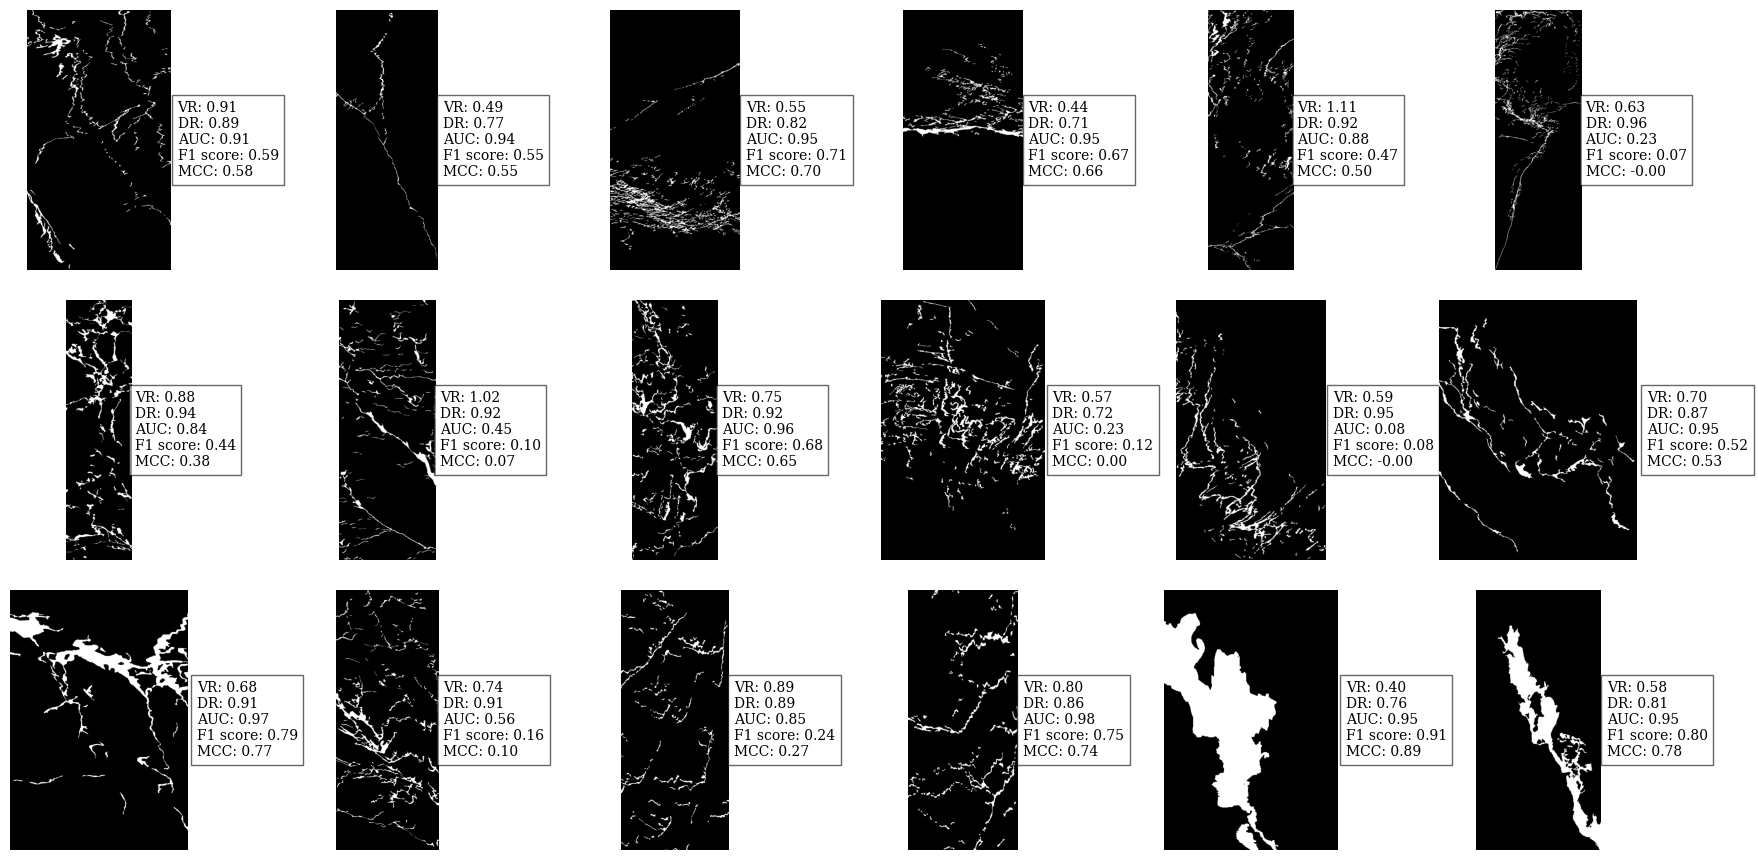

In [98]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
axes = axes.ravel()  # Flatten the 3x6 grid into a 1D array for easy indexing

# Iterate through images and DataFrame rows
for idx in range(1, 19):
    # Load the image
    mat = scipy.io.loadmat(data_dir + f'HSIoil/GM{idx:02}.mat')
    image = mat['map']

    # Get the row corresponding to the current image id
    row = df_test[df_test['id'] == idx].iloc[0]

    # Plot the image on the left side of the cell
    ax = axes[idx - 1]
    ax.imshow(image, cmap='gray')
    ax.axis('off')

    # Display metrics on the right side of the cell
    ax.text(1.05, 0.5, 
            f"VR: {row['VR']:.2f}\n"
            f"DR: {row['DR']:.2f}\n"
            f"AUC: {row['AUC']:.2f}\n"
            f"F1 score: {row['F1 score']:.2f}\n"
            f"MCC: {row['MCC']:.2f}",
            transform=ax.transAxes,
            verticalalignment='center',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

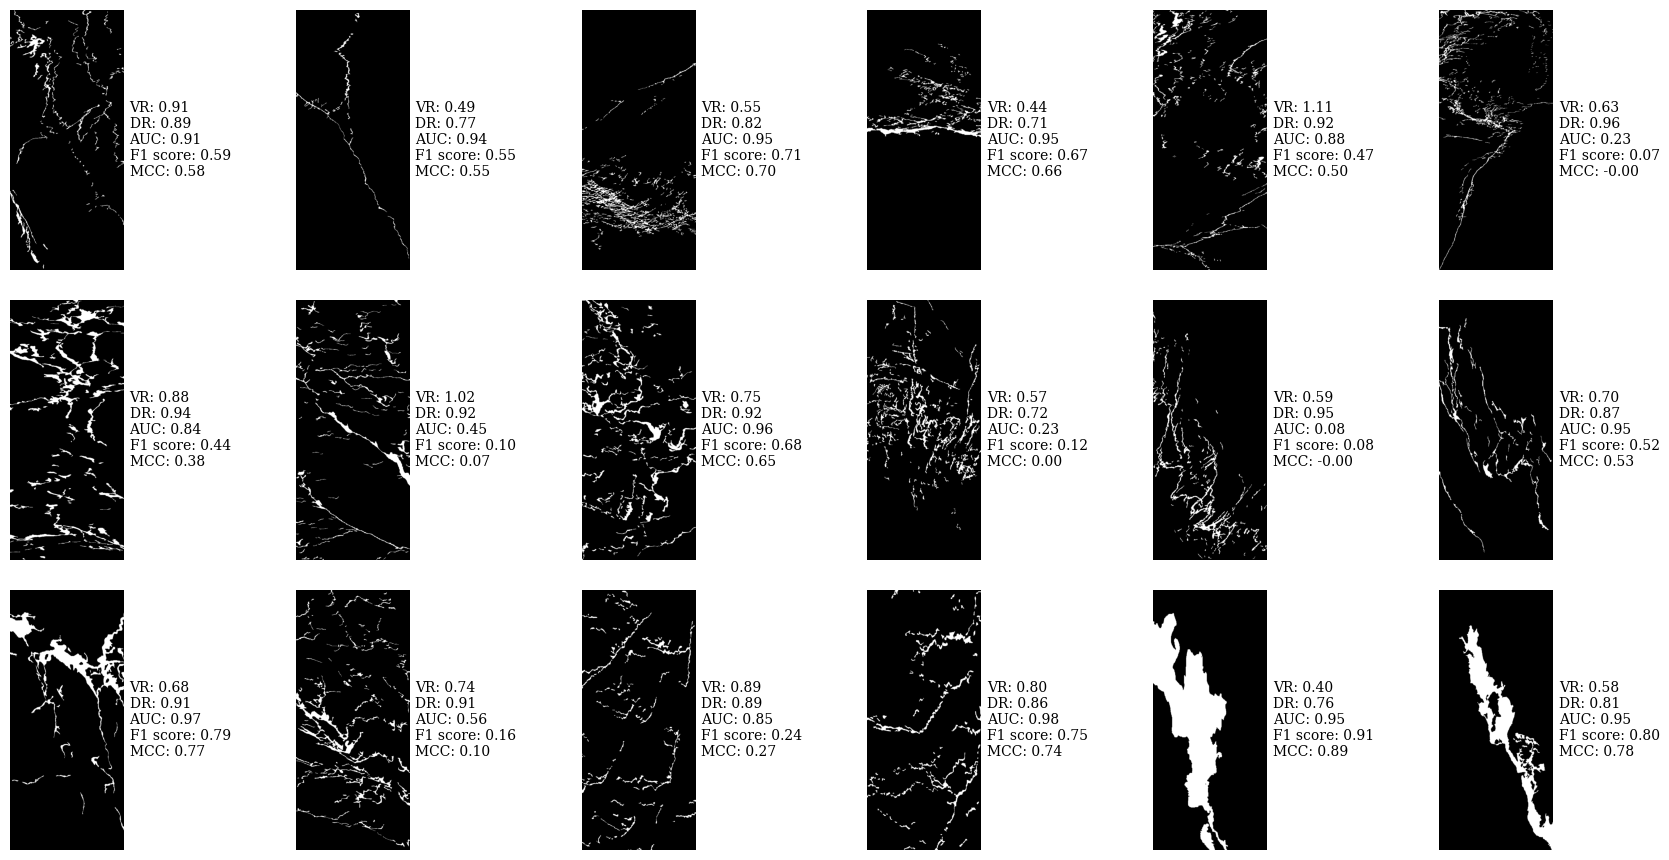

In [100]:
from PIL import Image

heights, widths = [], []
for im in range(1, 19):
    mat = scipy.io.loadmat(data_dir + f'HSIoil/GM{im:02}.mat')
    image = mat['map']
    heights.append(image.shape[0])
    widths.append(image.shape[1])

avg_height = int(np.mean(heights))
avg_width = int(np.mean(widths))

# Step 2: Create the plot with 3 rows and 6 columns
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
axes = axes.ravel()  # Flatten the 3x6 grid into a 1D array for easy indexing

# Step 3: Load each image, resize it, and plot with metrics
for idx in range(1, 19):
    # Load and resize the image
    mat = scipy.io.loadmat(data_dir + f'HSIoil/GM{idx:02}.mat')
    image = mat['map']
    image_resized = np.array(Image.fromarray(image).resize((avg_width, avg_height)))

    # Get the corresponding row in df_test
    row = df_test[df_test['id'] == idx].iloc[0]

    # Plot the image on the left side of the cell
    ax = axes[idx - 1]
    ax.imshow(image_resized, cmap='gray')
    ax.axis('off')

    # Display the metrics text on the right side of the cell
    metrics_text = (f"VR: {row['VR']:.2f}\n"
                    f"DR: {row['DR']:.2f}\n\n"
                    f"AUC: {row['AUC']:.2f}\n"
                    f"F1 score: {row['F1 score']:.2f}\n"
                    f"MCC: {row['MCC']:.2f}")

    ax.text(1.05, 0.5, metrics_text,
            transform=ax.transAxes,
            verticalalignment='center',
            fontsize=10)

plt.tight_layout()
plt.show()


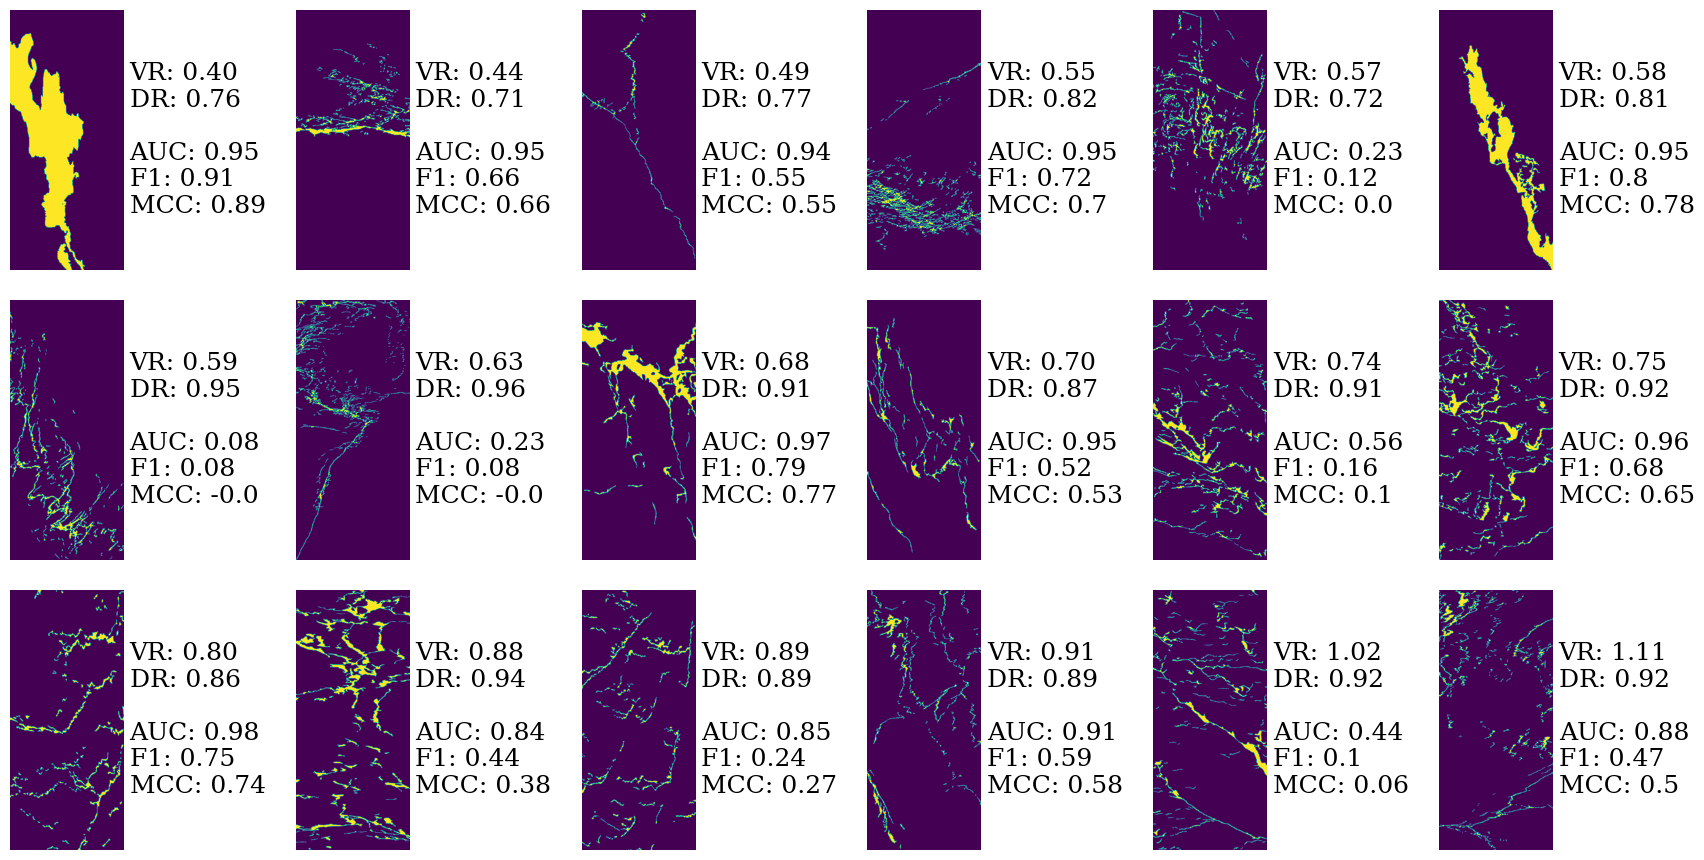

In [15]:
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import numpy as np
from PIL import Image

# Load your DataFrame with columns: 'id', 'VR', 'DR', 'AUC', 'F1', and 'MCC'
# Assuming `df_test` is already defined as per your description

# Step 1: Sort the DataFrame by VR in ascending order
df_test_sorted = df_test.sort_values(by='VR').reset_index(drop=True)

# Step 2: Calculate the average height and width of the images
heights, widths = [], []
for im in range(1, 19):
    mat = scipy.io.loadmat(data_dir + f'HSIoil/GM{im:02g}.mat')
    image = mat['map']
    heights.append(image.shape[0])
    widths.append(image.shape[1])

avg_height = int(np.mean(heights))
avg_width = int(np.mean(widths))

# Step 3: Create the plot with 3 rows and 6 columns
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
axes = axes.ravel()  # Flatten the 3x6 grid into a 1D array for easy indexing

# Step 4: Load each image based on sorted VR, resize it, and plot with metrics
for idx, row in df_test_sorted.iterrows():
    # Load and resize the image
    mat = scipy.io.loadmat(data_dir + f'HSIoil/GM{row["id"]:02g}.mat')
    image = mat['map']
    image_resized = np.array(Image.fromarray(image).resize((avg_width, avg_height)))

    # Plot the image on the left side of the cell
    ax = axes[idx]
    ax.imshow(image_resized, cmap='viridis')
    ax.axis('off')

    # Display the metrics text on the right side of the cell
    metrics_text = (f"VR: {row['VR']:.2f}\n"
                    f"DR: {row['DR']:.2f}\n\n"
                    f"AUC: {row['AUC'].round(2)}\n"
                    f"F1: {row['F1 score'].round(2)}\n"
                    f"MCC: {row['MCC'].round(2)}")

    ax.text(1.05, 0.5, metrics_text,
            transform=ax.transAxes,
            verticalalignment='center',
            fontsize=18)

plt.tight_layout()
# plt.savefig(root_dir+'/outputs/figs/TPAMI/locality_Oil_images.png')
plt.show()


In [101]:
df_test

,id,VR,DR,sample_id,AUC,F1 score,MCC
0,1,0.907164,0.886495,0,0.909,0.590,0.582
1,2,0.485913,0.769421,0,0.944,0.549,0.546
2,3,0.551378,0.823721,0,0.953,0.715,0.704
3,4,0.437424,0.709694,0,0.954,0.665,0.655
4,5,1.108509,0.920723,0,0.879,0.470,0.498
5,6,0.630040,0.956311,0,0.234,0.075,-0.002
6,7,0.883207,0.941959,0,0.841,0.444,0.382
7,8,1.020953,0.924778,0,0.445,0.097,0.065
8,9,0.753138,0.922990,0,0.958,0.676,0.648
9,10,0.566287,0.722353,0,0.227,0.116,0.003
